In [95]:
import talib
from talib import RSI, BBANDS, MACD, ATR
import joblib
import numpy as np
from datetime import datetime
import yfinance as yf
import pandas as pd

## Get data

In [96]:
TICKERS = ['ALUA.BA', 'AUSO.BA', 'BBAR.BA', 'BHIP.BA', 'BMA.BA', 'BOLT.BA',
       'BPAT.BA', 'BYMA.BA', 'CADO.BA', 'CAPX.BA', 'CARC.BA', 'CECO2.BA',
       'CELU.BA', 'CEPU.BA', 'CGPA2.BA', 'COME.BA', 'CRES.BA', 'CTIO.BA',
       'DGCU2.BA', 'DOME.BA', 'DYCA.BA', 'EDN.BA', 'FERR.BA', 'FIPL.BA',
       'GAMI.BA', 'GARO.BA', 'GBAN.BA', 'GCLA.BA', 'GGAL.BA', 'GRIM.BA',
       'HAVA.BA', 'INTR.BA', 'INVJ.BA', 'IRSA.BA', 'LEDE.BA', 'LOMA.BA',
       'LONG.BA', 'METR.BA', 'MIRG.BA', 'MOLA.BA', 'MOLI.BA', 'MORI.BA',
       'MTR.BA', 'OEST.BA', 'PAMP.BA', 'PATA.BA', 'POLL.BA', 'ROSE.BA',
       'SAMI.BA', 'SEMI.BA', 'SUPV.BA', 'TECO2.BA', 'TGNO4.BA', 'TGSU2.BA',
       'TRAN.BA', 'TXAR.BA', 'VALO.BA', 'YPFD.BA']

In [97]:
def get_data(end, size):
	n_tickers = 58 # hardcodeado

	DATA_STORE = './data/assets.h5'
	ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
	with pd.HDFStore(DATA_STORE) as store:
		last_date = store['merval/prices'].tail(1).index[0][0]
		first_date = store['merval/prices'].head(1).index[0][0]

		# check if data is enough.
		end_timestamp = pd.Timestamp(end)
		if last_date < end_timestamp:
			# load recent days
			stock_data = yf.download(TICKERS, start=last_date, end=end, progress=False)
			# TODO: parsear el resultado de yfinance y cargarlo al final de store['merval/prices']
			end_timestamp = stock_data.index[-1]

		# load data
		prices = (store['merval/prices']
				.loc[pd.IndexSlice[:end, :], ohlcv]
				.tail(n=size*n_tickers)
				.rename(columns=lambda x: x.replace('adj_', ''))
				.swaplevel()
				.sort_index())
	return prices

## Train model

In [98]:
YEAR = 252
idx = pd.IndexSlice
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
catboost_train_params = ['max_depth', 'min_child_samples']
lgb_daily_ic = pd.read_hdf('./data/lgbm_tuning.h5', 'lgb/daily_ic')

def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [99]:
lgb_daily_ic[lgb_daily_ic.lookahead==1].sort_values('ic', ascending=False).head(7)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
787,1,252,63,0.1,128,0.6,1000,250,0.087264
789,1,252,63,0.1,128,0.6,1000,350,0.087235
556,1,252,63,0.1,8,0.6,500,400,0.086992
552,1,252,63,0.1,8,0.6,500,200,0.086943
786,1,252,63,0.1,128,0.6,1000,200,0.086735
555,1,252,63,0.1,8,0.6,500,350,0.086617
557,1,252,63,0.1,8,0.6,500,450,0.086543


In [100]:
import lightgbm as lgb
def train_model(data):
	models = []
	for position in range(5):
		label = 'r1_fwd'
		features = data.columns.difference([label]).tolist()
		data = data.loc[pd.IndexSlice[:, :], features + [label]].dropna()
		categoricals = ['year', 'month', 'sector', 'weekday']
		for feature in categoricals:
			data[feature] = pd.factorize(data[feature], sort=True)[0]
		lgb_data = lgb.Dataset(data=data[features],
							label=data[label],
							categorical_feature=categoricals,
							free_raw_data=False)

		params = get_lgb_params(lgb_daily_ic,
							t=1,
							best=position)

		params = params.to_dict()
		for p in ['min_data_in_leaf', 'num_leaves']:
			params[p] = int(params[p])
		base_params = dict(boosting='gbdt', objective='regression', verbose=-1)
		num_boost_round = int(params.pop('boost_rounds'))
		params.update(base_params)

		model = lgb.train(params=params,
						train_set=lgb_data,
						num_boost_round=num_boost_round)
		models.append(model)
	return models

## Engineer data

In [101]:
import talib
from talib import RSI, BBANDS, MACD, ATR
def engineer_data(data):
    prices = data.sort_index()
    DATA_STORE = './data/assets.h5'
    with pd.HDFStore(DATA_STORE) as store:
        metadata = (store['merval/stocks'].loc[:, ['marketcap', 'sector']])

    prices.volume /= 1e3 # make vol figures a bit smaller
    prices.index.names = ['symbol', 'date']
    metadata.index.name = 'symbol'

    # RSI
    rsi = prices.groupby(level='symbol').close.apply(RSI)
    prices['rsi'] = rsi.values

    # BB
    def compute_bb(close):
        high, mid, low = BBANDS(close, timeperiod=20)
        return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)
    bb = prices.groupby(level='symbol').close.apply(compute_bb)
    prices['bb_high'] = bb['bb_high'].values
    prices['bb_low'] = bb['bb_low'].values
    prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
    prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

    # NATR
    prices['NATR'] = prices.groupby(level='symbol', 
                                group_keys=False).apply(lambda x: 
                                                        talib.NATR(x.high, x.low, x.close))
    def compute_atr(stock_data):
        df = ATR(stock_data.high, stock_data.low, 
                stock_data.close, timeperiod=14)
        return df.sub(df.mean()).div(df.std())
    prices['ATR'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_atr))
    
    # PPO
    by_ticker = prices.groupby('symbol', group_keys=False)
    prices['ppo'] = by_ticker.close.apply(talib.PPO)
    
    # MACD
    def compute_macd(close):
        macd = MACD(close)[0]
        return (macd - np.mean(macd))/np.std(macd)
    prices['MACD'] = (prices
                  .groupby('symbol', group_keys=False)
                  .close
                  .apply(compute_macd))
    
    # Combine price and metadata
    metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
    prices = prices.join(metadata[['sector']])

    # Create dummy variables
    prices['year'] = prices.index.get_level_values('date').year
    prices['month'] = prices.index.get_level_values('date').month
    prices['weekday'] = prices.index.get_level_values('date').weekday

    # Compute forward returns (labels)
    by_sym = prices.groupby(level='symbol').close
    prices['r1'] = by_sym.pct_change(1)
    prices['r1_fwd'] = prices.groupby(level='symbol')['r1'].shift(-1)
    return prices

## Make prediction (and train if needed)

In [102]:
current_model = None
last_training = None
N_LONGS = 52

def get_prediction(date):
	global current_model
	global last_training
	
	size = 34 # min size to be able to compute macd
	# Check if retraining is needed
	training_needed = not current_model or abs((last_training - pd.to_datetime(date)).days) > 63
	if training_needed:
		size += 252
		last_training = pd.to_datetime(date)

	# get data from last 252 days
	data = get_data(date, size)
	data.dropna(inplace=True)

	# Engineer input data
	daily_df = engineer_data(data)
	today_df = daily_df.xs(key=date, level='date').drop(columns=['r1_fwd'])

	# Train model if needed
	if training_needed:
		current_model = train_model(daily_df)

	# Predict with model
	predictions = []
	for model in current_model:
		predictions.append(model.predict(today_df.loc[:, model.feature_name()]))
	prediction = sum(predictions) / len(predictions)
	today_df = today_df.assign(prediction=prediction)

	# Apply strategy
	top_predictions = today_df[today_df['prediction'] > 0].nlargest(N_LONGS, 'prediction')
	open_positions  = dict()
	if len(top_predictions) == 0:
		open_positions['cash'] = 1
	else:
		allocation = 1 / len(top_predictions)
		for ticker in top_predictions.index:
			open_positions[ticker] = allocation
	return open_positions, today_df

## Backtest

In [103]:
START = '2018'
END = '2021'

DATA_STORE = './data/assets.h5'
with pd.HDFStore(DATA_STORE) as store:
    prices = store['merval/prices'].sort_index()['close'].loc[pd.IndexSlice[START:END]]
date_index = prices.index.get_level_values(0).unique()

In [ ]:
import pandas as pd

# date = datetime.today().strftime('%Y-%m-%d')

def backtest(dates, initial_capital=1):
	portfolio_value = []
	open_positions = dict()
	prev_prices = dict()
	positions = []
	value = initial_capital

	for date in dates:
		daily_df = get_data(date, 1)

		# sell assets and add value
		if len(open_positions) > 0:
			value = 0
			for (ticker, alloc) in open_positions.items():
				if ticker == 'cash':
					value += alloc
				else:
					try:
						price = daily_df.loc[ticker, 'close'].values[0]
					except:
						price = prev_prices[ticker]
					value += price * alloc
		portfolio_value.append(value)

		open_positions, today_df = get_prediction(date)
		
		# buy the assets
		for ticker, fraction in open_positions.items():
			if ticker == 'cash':
				price = 1
			else:
				price = today_df.loc[ticker, 'close']
				prev_prices[ticker] = price
			open_positions[ticker] = value * fraction / price

		positions.append(open_positions)

	return portfolio_value, positions

portfolio_value, positions = backtest(date_index)

In [ ]:
portfolio_df = pd.DataFrame({
    'portfolio_value': portfolio_value,
	'positions': positions
}, index=date_index)
portfolio_df.sort_index(inplace=True)
portfolio_df.reset_index(inplace=True)
portfolio_df

,date,portfolio_value,positions
0,2018-01-01,1.000000,"{'CGPA2.BA': 0.00296540000898181, 'MOLA.BA': 0..."
1,2018-01-02,1.030874,"{'METR.BA': 0.0044338671262102785, 'PAMP.BA': ..."
2,2018-01-03,1.055162,"{'PAMP.BA': 0.004073985426729759, 'DGCU2.BA': ..."
3,2018-01-04,1.083524,"{'CELU.BA': 0.011199218657992569, 'CEPU.BA': 0..."
4,2018-01-05,1.097110,"{'PAMP.BA': 0.004195450467911851, 'TRAN.BA': 0..."
...,...,...,...
726,2020-12-23,40.847304,"{'MIRG.BA': 0.005372558209974612, 'BBAR.BA': 0..."
727,2020-12-28,40.439852,"{'TXAR.BA': 0.1985324783270967, 'MIRG.BA': 0.0..."
728,2020-12-29,41.299486,"{'MIRG.BA': 0.005333613758985105, 'LONG.BA': 1..."
729,2020-12-30,41.168350,"{'MIRG.BA': 0.005240058708042865, 'MOLA.BA': 0..."


## Analyze results

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_datareader.data as web

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [ ]:
df_expanded = portfolio_df['positions'].apply(pd.Series).fillna(0)
positions_df = pd.concat([portfolio_df['date'], df_expanded], axis=1)
positions_df['date'] = pd.to_datetime(positions_df['date'])
positions_df = positions_df.set_index(['date'])

Graficar resultados

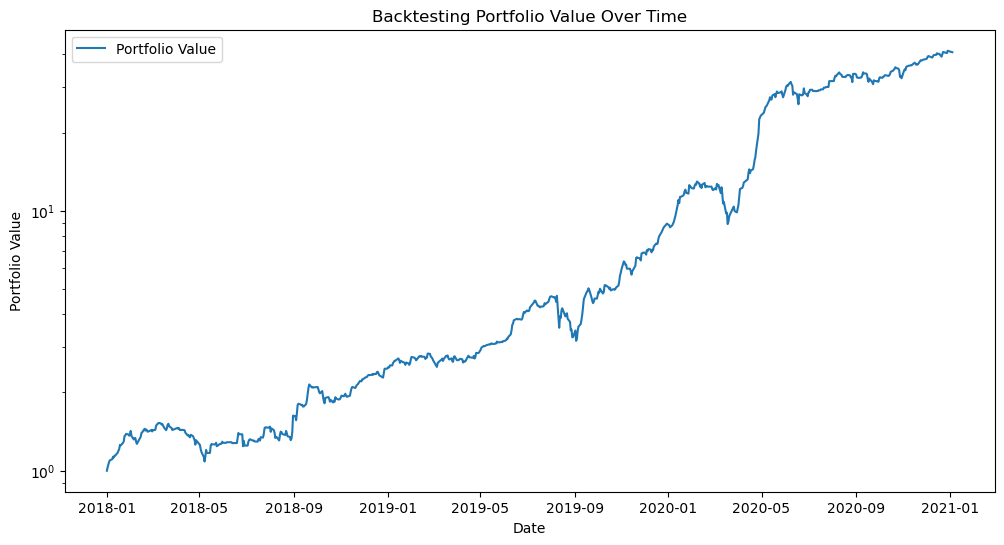

In [ ]:
# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['date'], portfolio_df['portfolio_value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.yscale('log')
plt.title('Backtesting Portfolio Value Over Time')
plt.legend()
plt.show()


In [ ]:
portfolio_df = portfolio_df.set_index(['date'])

In [ ]:
DATA_STORE = './data/assets.h5'
ohlcv = ['open', 'close', 'low', 'high', 'volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['merval/prices'][ohlcv])


## Metrics in USD

Get dolar "BOLSA" price

In [ ]:
import requests
import pandas as pd

# Función para obtener los tipos de cambio de dolarhoy.com
def get_exchange_rate_history():
    url = "https://api.argentinadatos.com/v1/cotizaciones/dolares/blue"
    response = requests.get(url)
    data = response.json()

    # Filtrar los datos para incluir solo aquellos con casa: "blue"
    exchange_rates = [
        {'date': item['fecha'], 'exchange_rate': item['venta']}
        for item in data
    ]

    # Convertir a DataFrame
    df_exchange_rates = pd.DataFrame(exchange_rates)
    
    # Convertir la columna 'date' a datetime
    df_exchange_rates['date'] = pd.to_datetime(df_exchange_rates['date'], format='%Y-%m-%d')
    
    return df_exchange_rates

exchange_rates = get_exchange_rate_history()

In [ ]:
exchange_rates = exchange_rates.set_index('date')

In [ ]:
exchange_rates = exchange_rates.reindex(portfolio_df.index)

In [ ]:
a = portfolio_df['portfolio_value'] / exchange_rates['exchange_rate']
portfolio_df['portfolio_value'] = a / a[0]

## PyFolio Analysis

In [ ]:
returns = portfolio_df['portfolio_value'].pct_change().tz_localize('UTC')

In [ ]:
sp_merval = pd.read_csv('./data/merval.csv')
sp_merval = sp_merval[['Date','Adj Close']].rename(columns={'Date':'date', 'Adj Close':'MERVAL'})
sp_merval['date'] = pd.to_datetime(sp_merval['date'])

In [ ]:
sp_merval = sp_merval.set_index(['date'])
sp_merval = sp_merval.reindex(portfolio_df['portfolio_value'].index)

# Express results in USD
sp_merval['MERVAL'] = sp_merval['MERVAL'] / exchange_rates['exchange_rate']


In [ ]:
benchmark = sp_merval['MERVAL'].pct_change().tz_localize('UTC')
benchmark = benchmark.reindex(returns.index)

In [ ]:
import yfinance as yf

start_date = '2020-01-01'
end_date = '2024-01-01'
sp500_values = yf.download('SPY', start=start_date, end=end_date)['Adj Close']
sp500_values

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02    303.135498
2020-01-03    300.840179
2020-01-06    301.987854
2020-01-07    301.138794
2020-01-08    302.743713
                 ...    
2023-12-22    470.664490
2023-12-26    472.651886
2023-12-27    473.506470
2023-12-28    473.685333
2023-12-29    472.314026
Name: Adj Close, Length: 1006, dtype: float64

In [ ]:
sp500_benchmark = sp500_values.pct_change().tz_localize('UTC').reindex(returns.index)

### Custom Plots

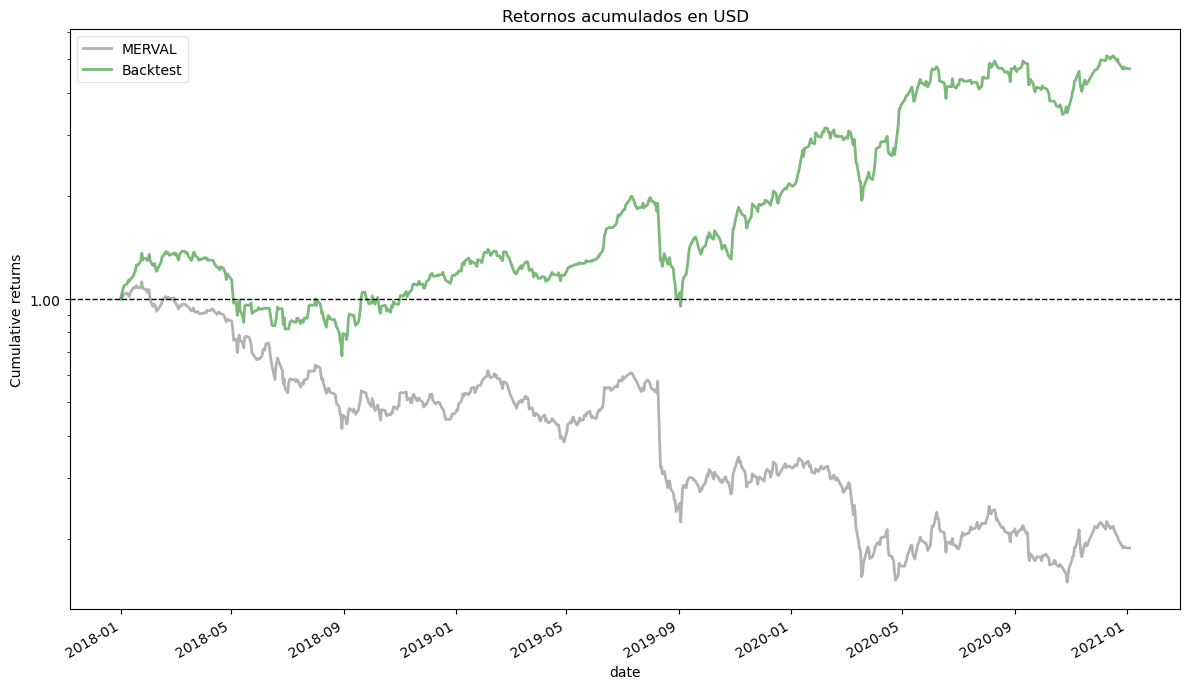

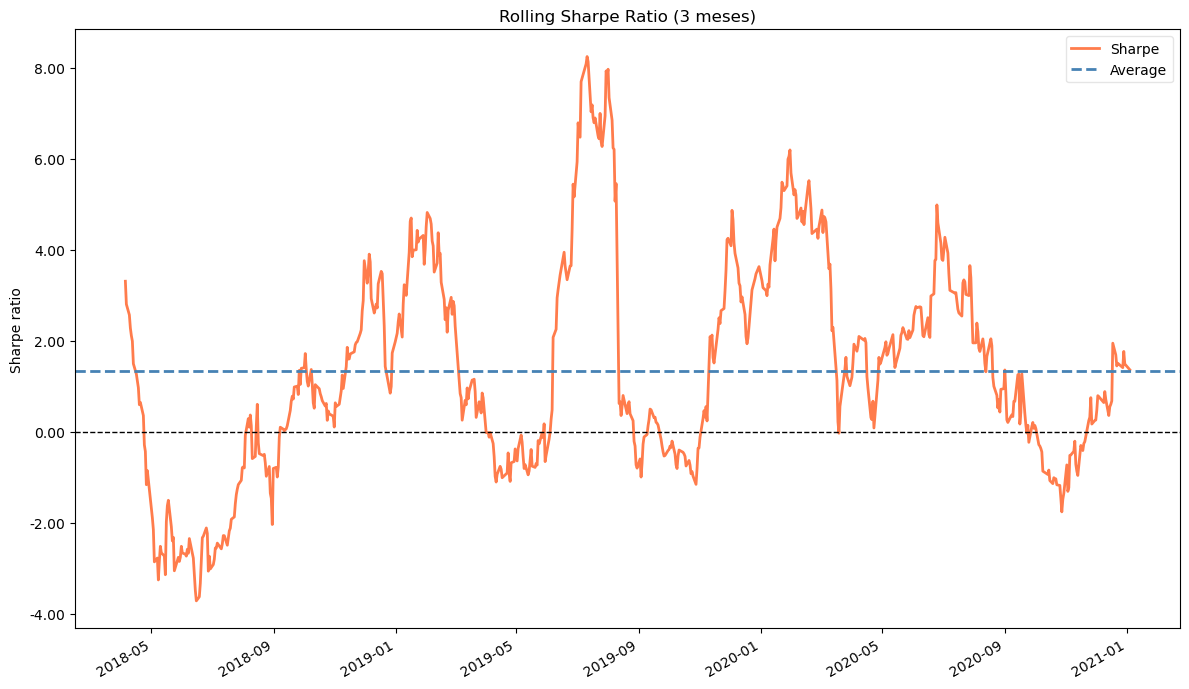

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
plot_rolling_returns(
    returns,
    factor_returns=benchmark,
    live_start_date=None,
    logy=True,
    cone_std=2,
    legend_loc='best',
    volatility_match=False,
    cone_function=forecast_cone_bootstrap,
    ax=ax1
)
ax1.set_title('Retornos acumulados en USD')
fig1.tight_layout()

fig2, ax2 = plt.subplots(figsize=(12, 7))
plot_rolling_sharpe(returns, ax=ax2, rolling_window=63)
ax2.set_title('Rolling Sharpe Ratio (3 meses)')
fig2.tight_layout()

plt.show()


Compute anualized variation of merval:

In [ ]:
first_row = sp_merval.iloc[1]
last_row = sp_merval.iloc[-1]
increase = (last_row['MERVAL'] / first_row['MERVAL'])
print(f'The MERVAL index grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The MERVAL index grew by x0.187934
Anualized is: %57.279875


In [ ]:
first_row = portfolio_df.iloc[0]
last_row = portfolio_df.iloc[-1]
increase = (last_row['portfolio_value'] / first_row['portfolio_value'])
print(f'The PORTFOLIO grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The PORTFOLIO grew by x4.693081
Anualized is: %167.424629


In [ ]:
first_row = sp500_values.iloc[0]
last_row = sp500_values.iloc[-1]
increase = (last_row / first_row)
print(f'The SP500 grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The SP500 grew by x1.558095
Anualized is: %115.930582


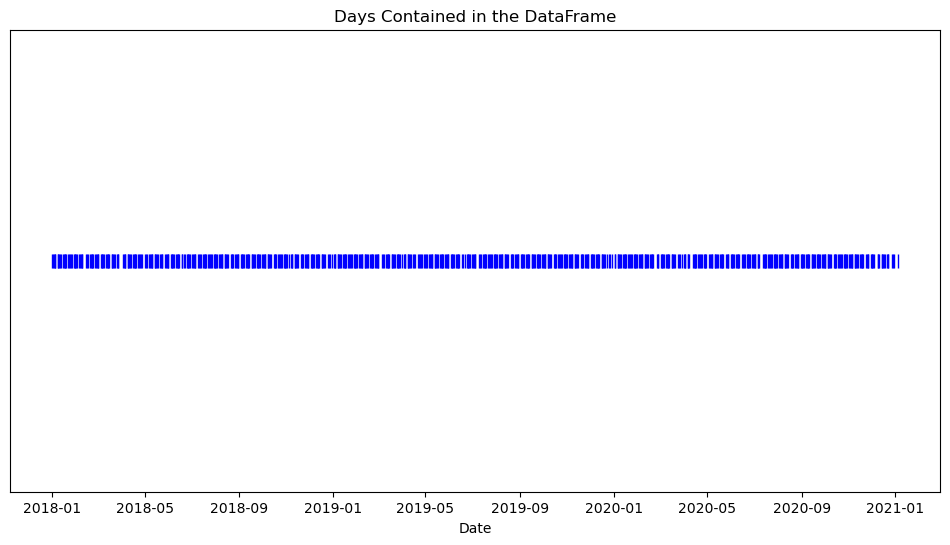

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ejemplo de creación de DataFrame
dates = portfolio_df.index
portfolio_values = portfolio_df['portfolio_value']
df = pd.DataFrame({'portfolio_value': portfolio_values}, index=dates)

# Crear una serie de datos indicando los días contenidos en el DataFrame
days_in_df = df.index

# Graficar los días contenidos en el DataFrame
plt.figure(figsize=(12, 6))
plt.plot(days_in_df, [1]*len(days_in_df), '|', color='blue', markersize=10)  # Use pipe marker to indicate dates
plt.xlabel('Date')
plt.title('Days Contained in the DataFrame')
plt.yticks([])  # Remove y-axis ticks since we only care about the dates
plt.show()


### Tear Sheets

In [ ]:
positions_df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-08', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-28', '2020-12-29',
               '2020-12-30', '2021-01-04'],
              dtype='datetime64[ns]', name='date', length=731, freq=None)

/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered 

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.20,2019-07-11,2019-09-03,2019-12-13,112
1,50.49,2018-03-09,2018-08-30,2019-02-05,238
2,38.51,2020-02-07,2020-03-18,2020-04-27,57
3,30.24,2020-09-10,2020-10-23,2020-12-04,62
4,19.43,2019-02-05,2019-04-09,2019-06-11,91


/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/pyfolio/plotting.py:1407: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
New Normal,0.09%,-10.04%,16.09%
Covid,0.26%,-13.16%,16.55%


Top 10 long positions of all time,max
CEPU.BA,100.00%
GARO.BA,100.00%
GRIM.BA,100.00%
BPAT.BA,100.00%
GCLA.BA,100.00%
AUSO.BA,100.00%
DOME.BA,100.00%
GAMI.BA,97.92%
CARC.BA,96.92%
FERR.BA,96.62%


Top 10 short positions of all time,max


Top 10 positions of all time,max
CEPU.BA,100.00%
GARO.BA,100.00%
GRIM.BA,100.00%
BPAT.BA,100.00%
GCLA.BA,100.00%
AUSO.BA,100.00%
DOME.BA,100.00%
GAMI.BA,97.92%
CARC.BA,96.92%
FERR.BA,96.62%


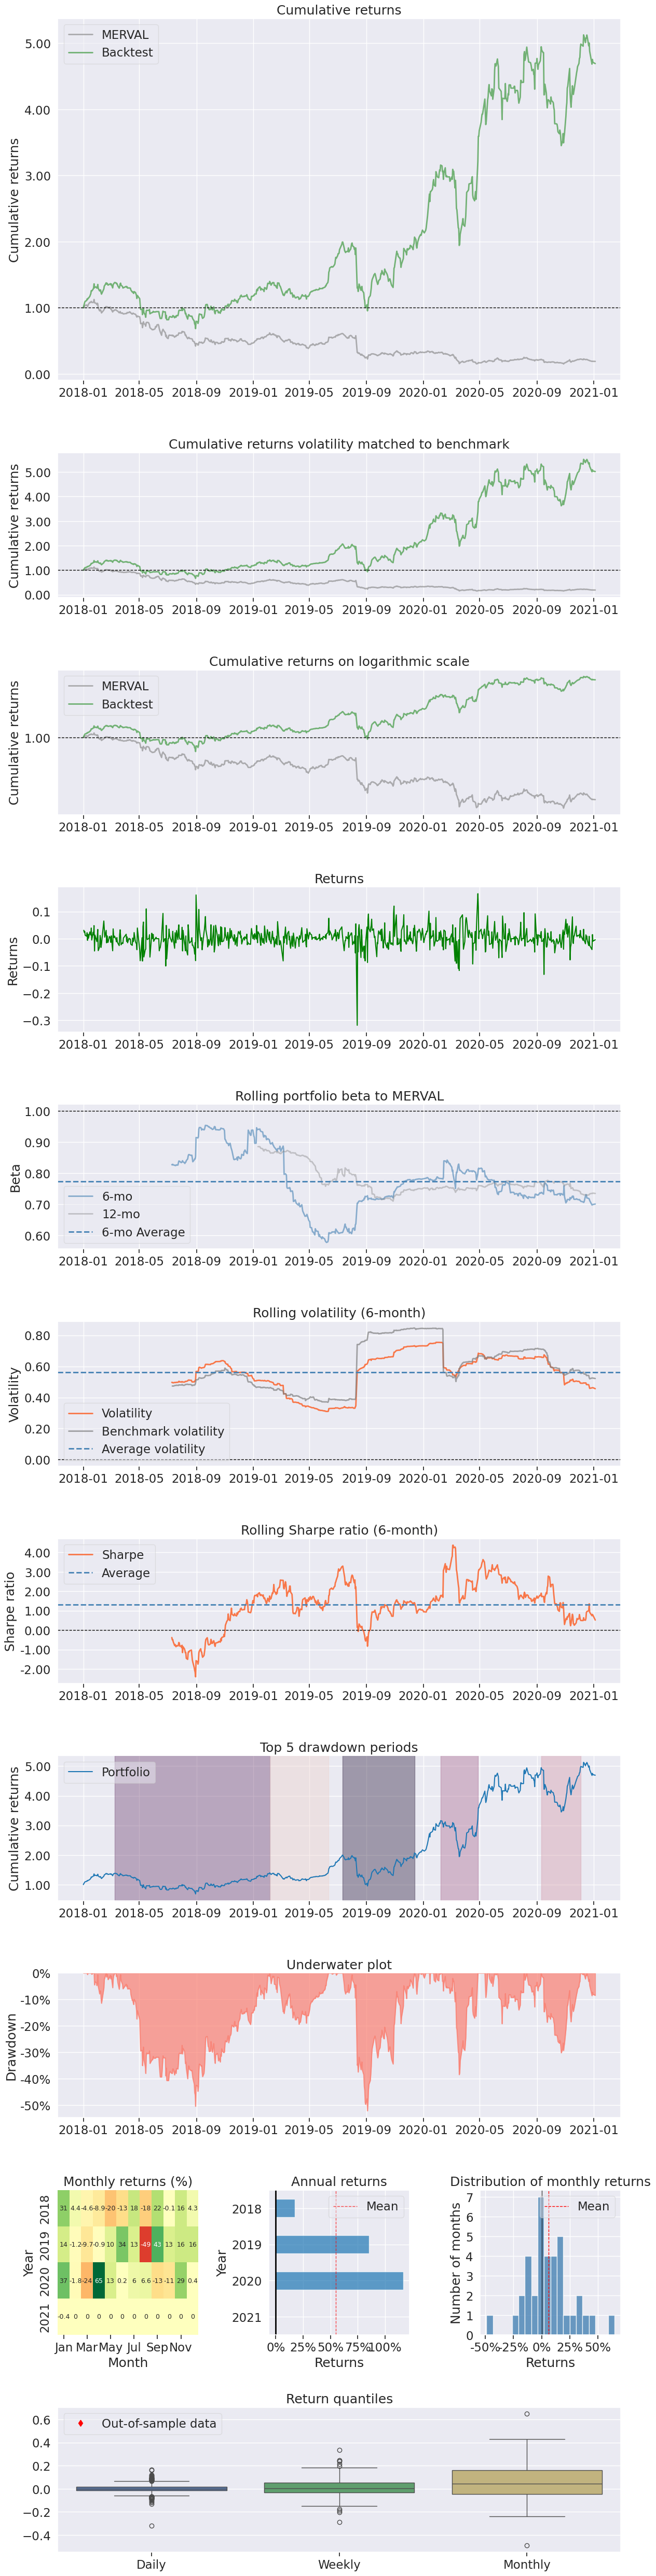

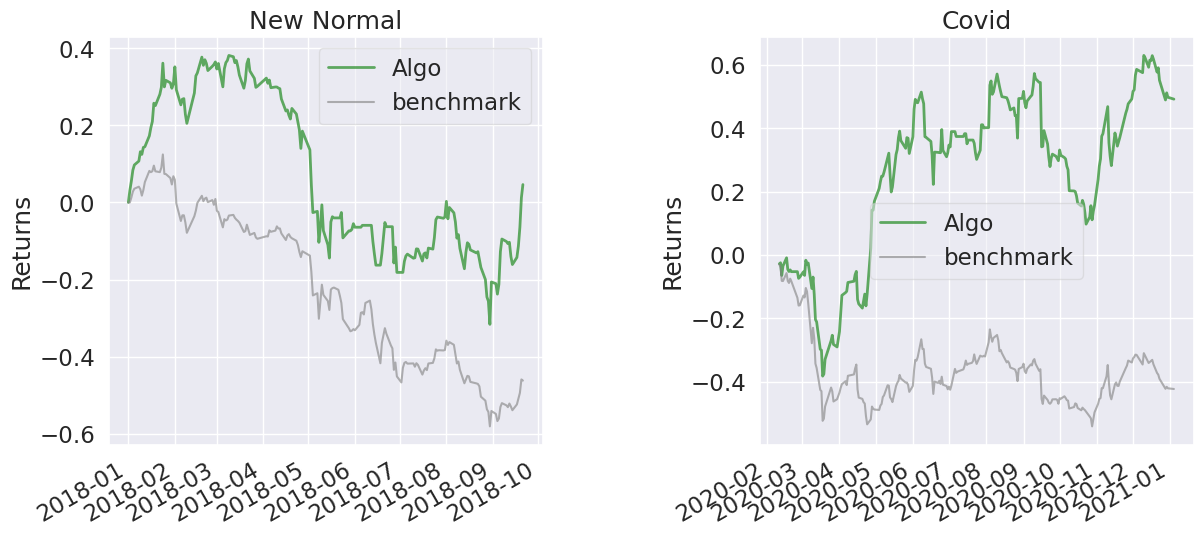

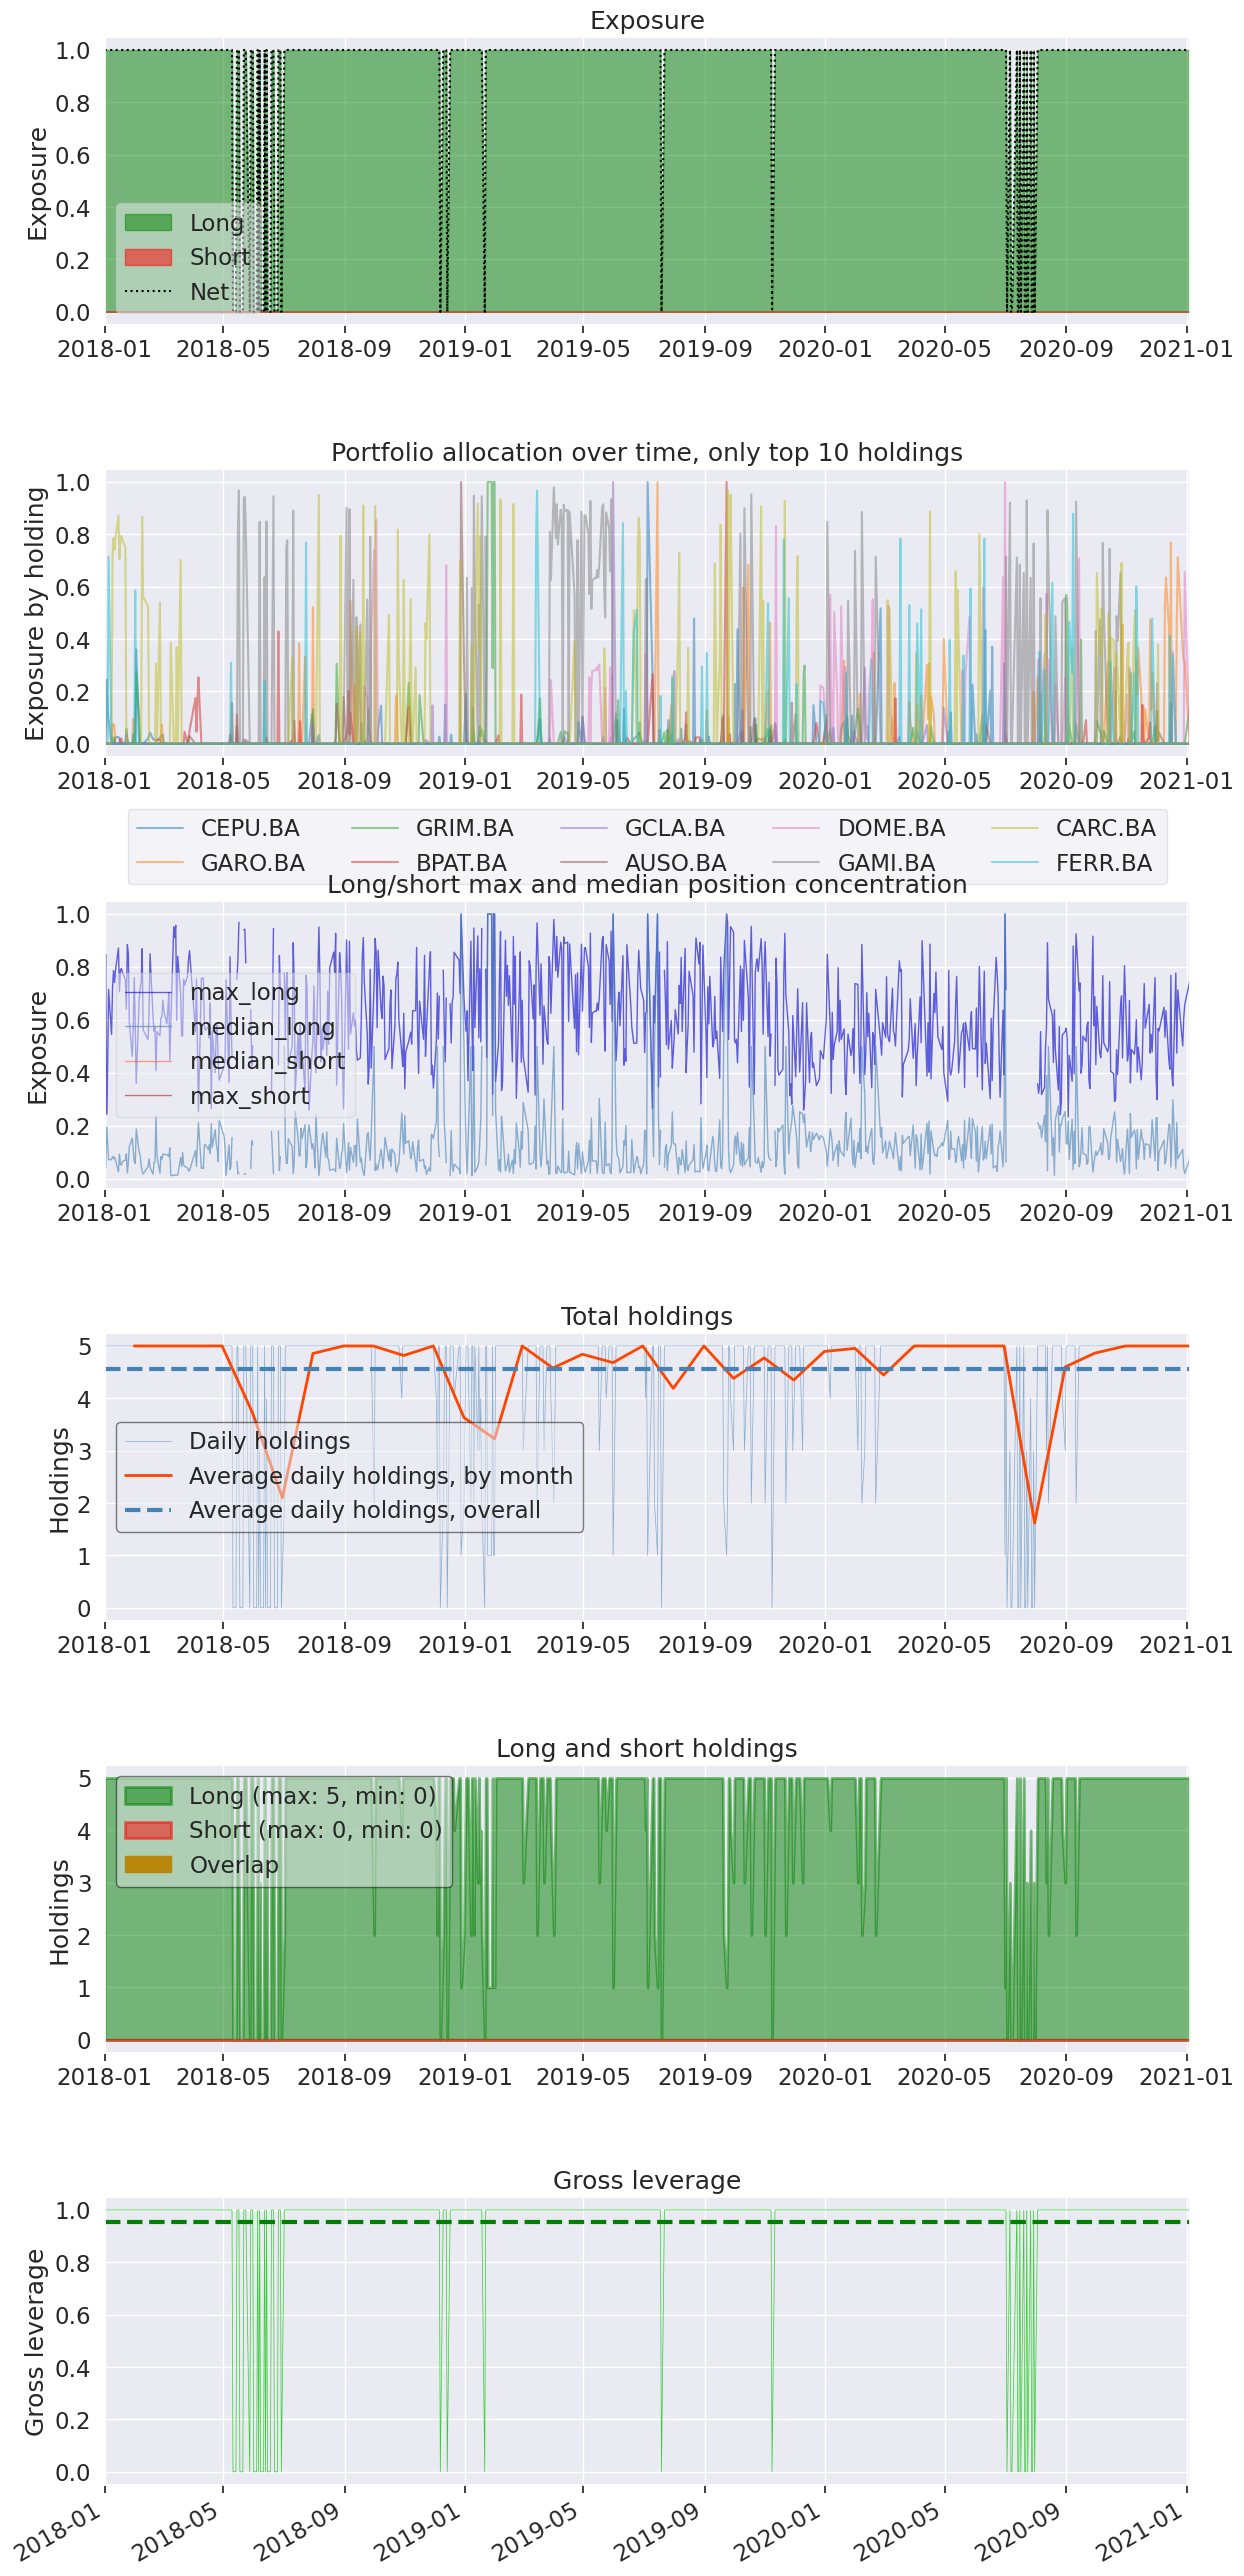

In [ ]:
pf.create_full_tear_sheet(returns, 
                          positions=positions_df.tz_localize('UTC'), 
                          transactions=None,
                          benchmark_rets=benchmark,
                          live_start_date='2022-01-01', 
                          round_trips=True)